In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [4]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.970421     0.674428
1  0.004004  0.970413     0.674197
2  0.006006  0.970405     0.673962
3  0.007936  0.970397     0.673722
4  0.009009  0.970389     0.673347


# Magnetic Field - B [G]

In [4]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.97266742, 0.97265995, 0.97265246, 0.97264495, 0.97263743])

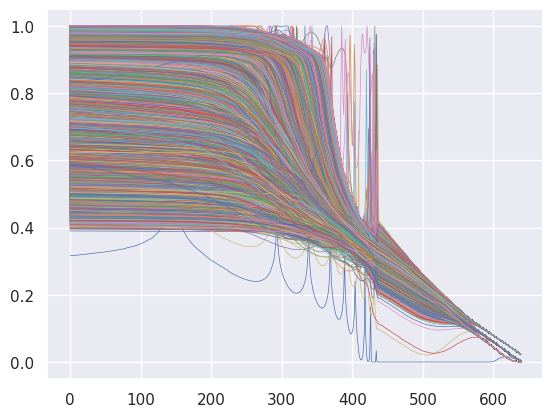

In [5]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

## PCA

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0),
 Text(0.5, 1.0, 'Magnetic Field Explained Variance')]

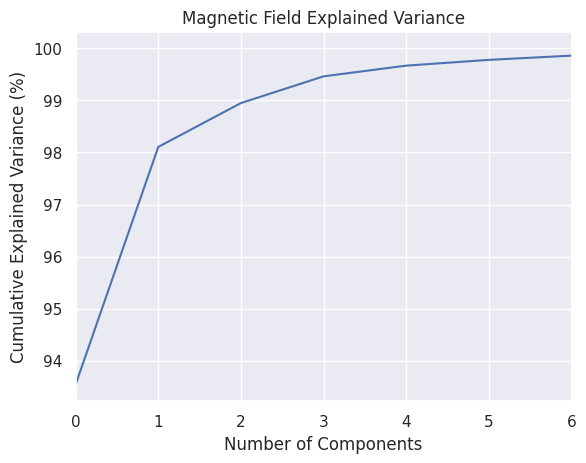

In [14]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_magnetic)
transf_pca_640 = pca_640.transform(scaled_magnetic)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6),
       title="Magnetic Field Explained Variance")

In [7]:
pca = PCA(n_components=2)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[-4.28982886,  1.10740619],
       [ 1.36459662, -0.28275395],
       [ 2.0978725 ,  0.33036765],
       ...,
       [-1.62062591, -0.48384266],
       [ 2.28354529, -0.28899915],
       [-0.63886752, -0.71360391]])

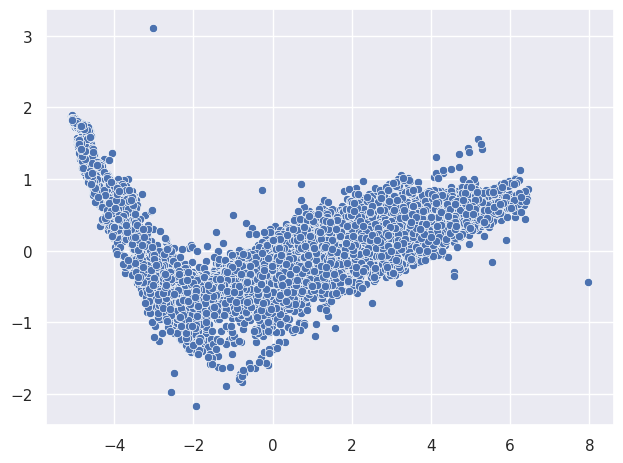

In [16]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])
# plt.title("Magnetic Field PCA")
plt.tight_layout()

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

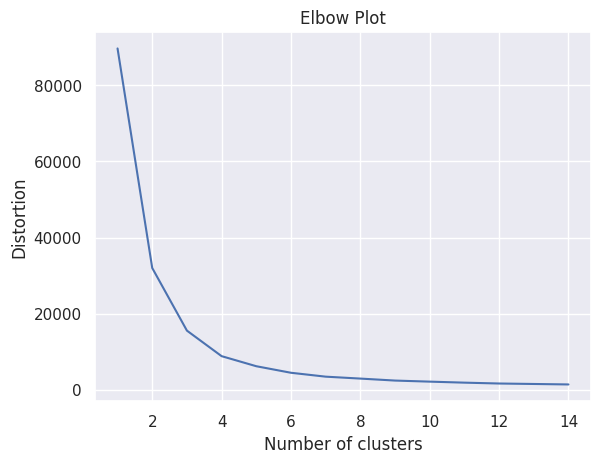

In [9]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto', random_state=1)
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [10]:
df= clustering_metrics(KMeans, transformed_mag, {"n_init": "auto", "max_iter": 5000, "random_state": 1})
df

K   S score        DB            CH
0  2  0.538303  0.644588  21224.596505
1  3  0.534043  0.585570  28086.939488
2  4  0.531091  0.549076  35942.377312
3  5  0.501803  0.578599  39762.799033
4  6  0.493761  0.592003  44986.216765
5  7  0.485591  0.599818  49233.075868
6  8  0.453792  0.637335  49757.447407
7  9  0.456504  0.635794  53265.315795

In [11]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.538 & 0.645 & 21224.597 \\
3 & 0.534 & 0.586 & 28086.939 \\
4 & 0.531 & 0.549 & 35942.377 \\
5 & 0.502 & 0.579 & 39762.799 \\
6 & 0.494 & 0.592 & 44986.217 \\
7 & 0.486 & 0.600 & 49233.076 \\
8 & 0.454 & 0.637 & 49757.447 \\
9 & 0.457 & 0.636 & 53265.316 \\
\bottomrule
\end{tabular}



In [13]:
nclusters=4
kmeans = KMeans(n_clusters=nclusters,max_iter=5000, n_init='auto', random_state=1)
pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

<Axes: >

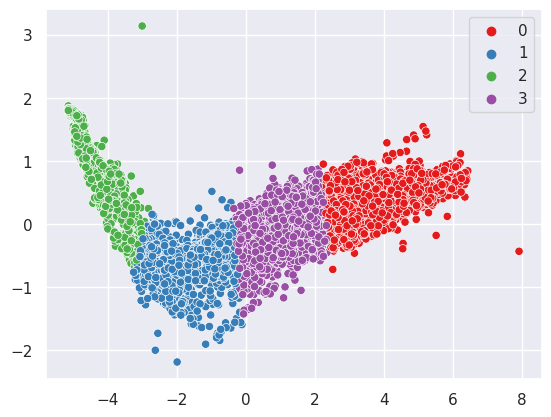

In [14]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

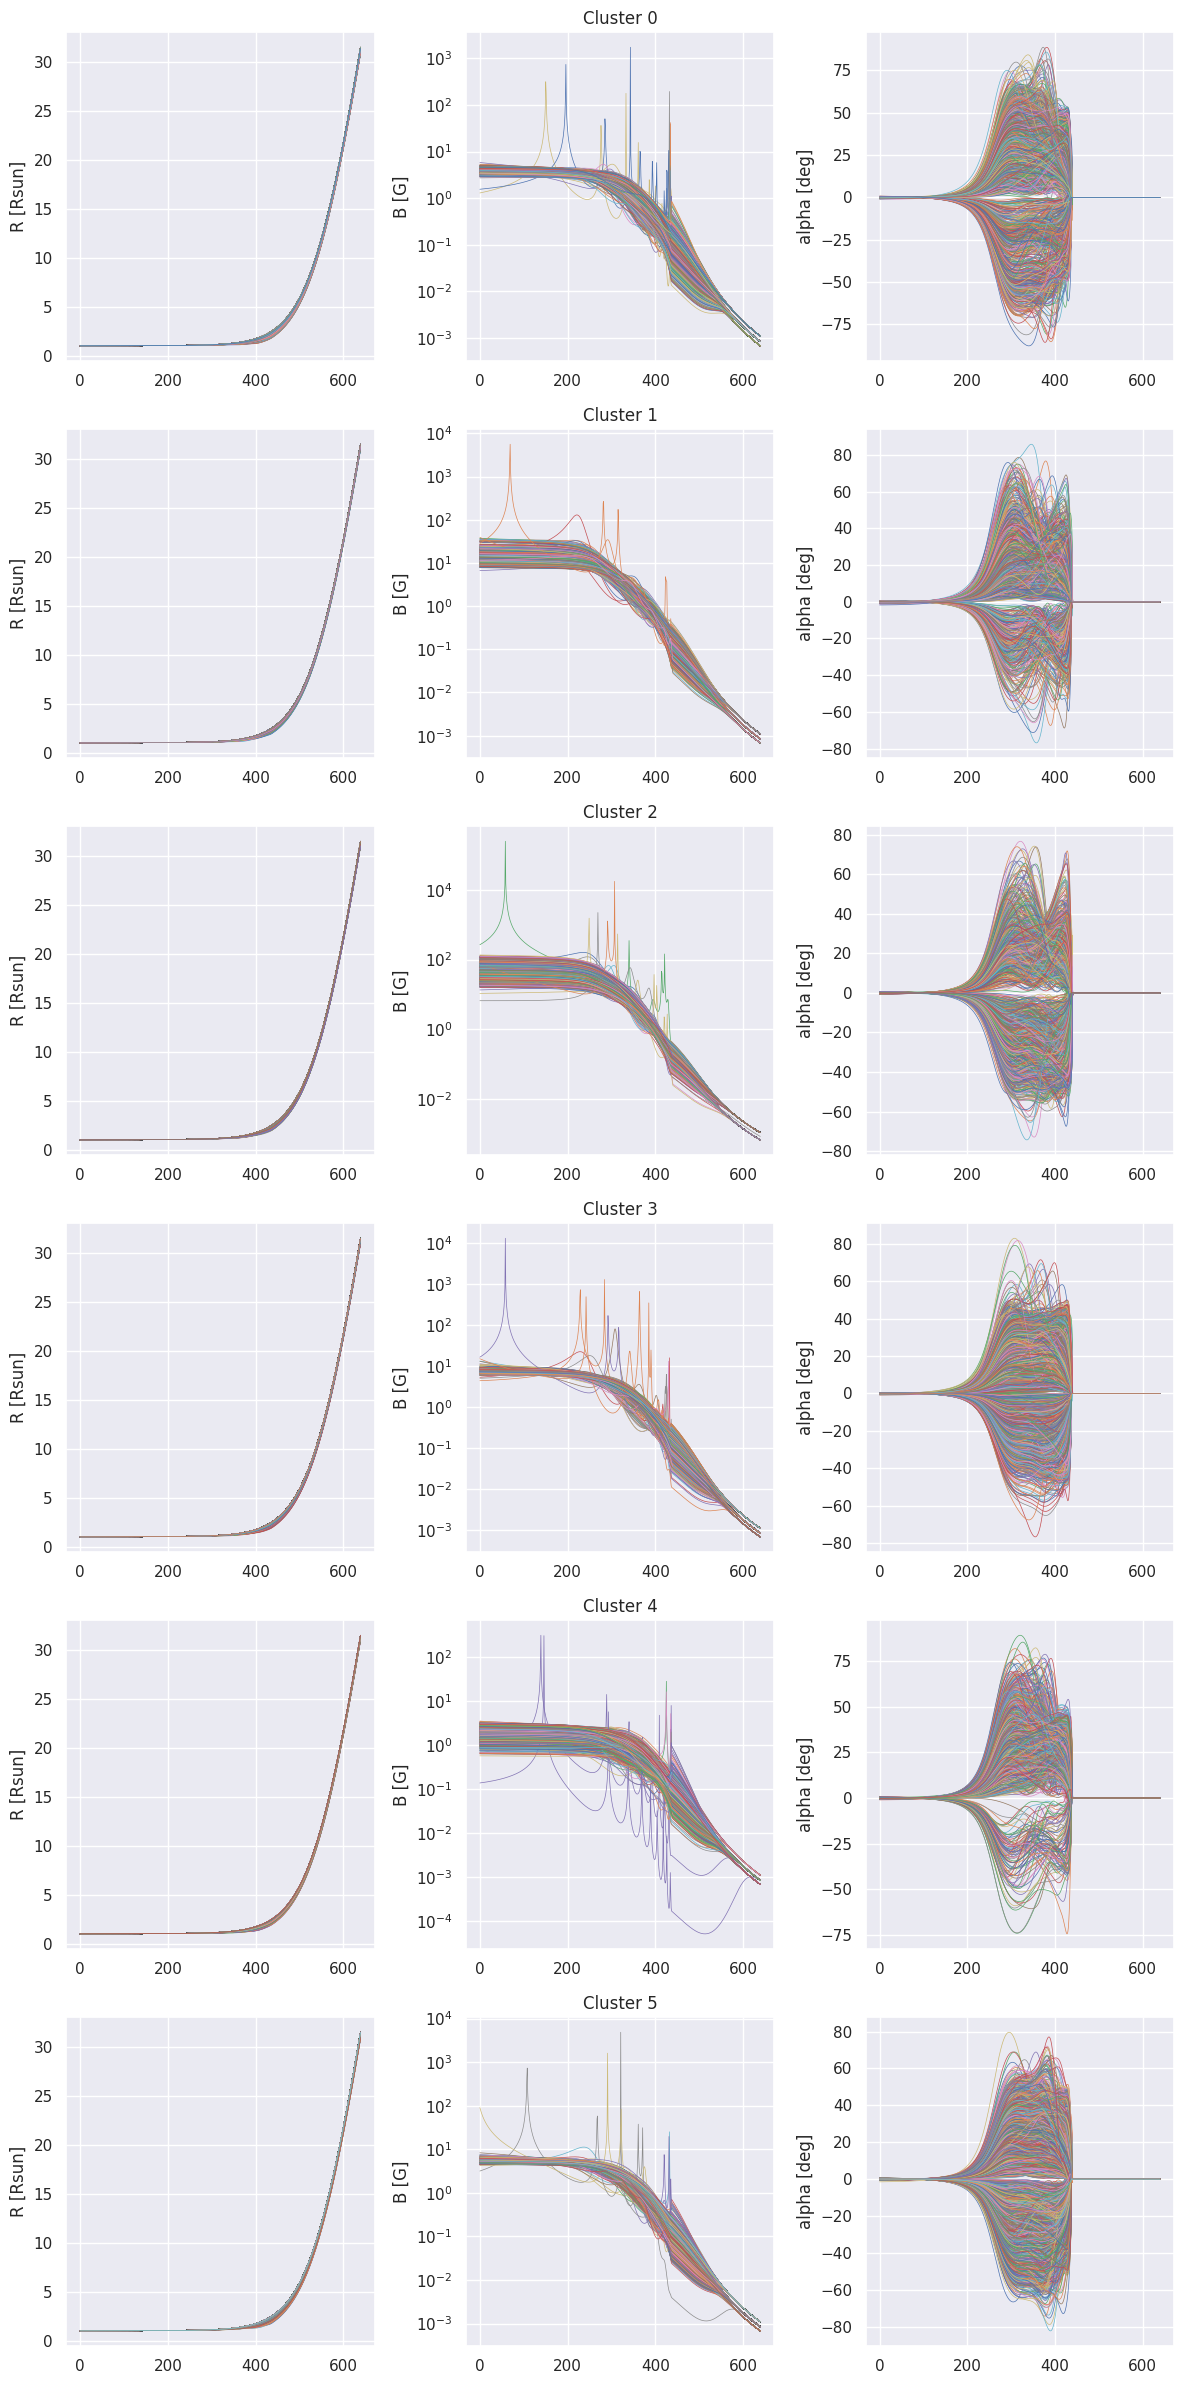

In [ ]:
plot_unscaled_clusters(pca_kmeans_mag_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

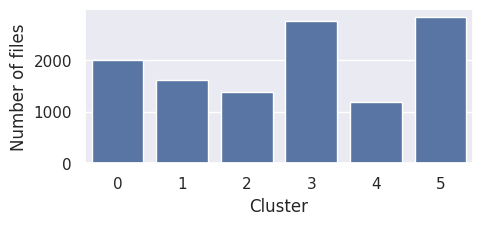

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [213, 701, 777, 303, 27, 479], 'CR2056': [374, 98, 1, 1192, 95, 802], 'CR2071': [474, 0, 0, 748, 396, 555], 'CR2125': [398, 459, 608, 130, 183, 285], 'CR2210': [532, 350, 0, 379, 493, 719]}
[0, 1, 2, 3, 4, 5]


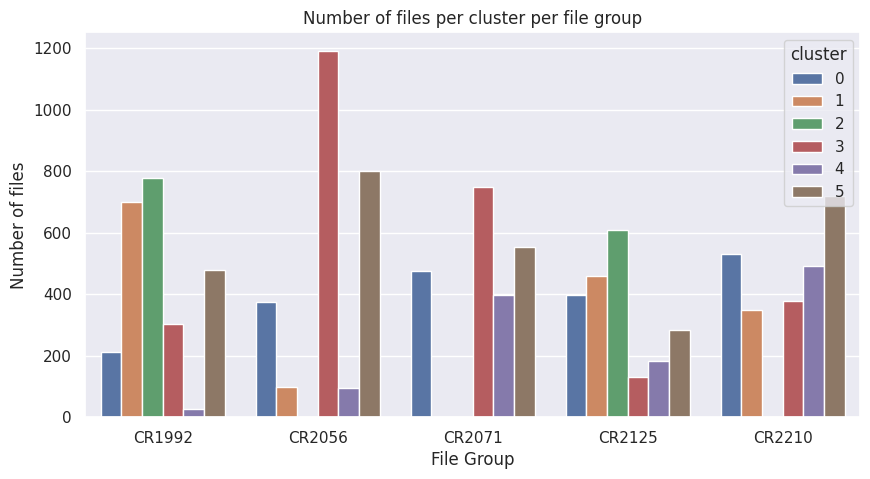

In [ ]:
fig = plot_cluster_file_group(filenames, pca_kmeans_mag_labels, nclusters)

## Bissecting K-Means

In [ ]:
clustering_metrics(BisectingKMeans, transformed_mag, { "random_state": 1})

n_clusters  silhouette  davies_bouldin  calinski_harabasz
0            2    0.535481        0.652056       21017.561117
1            3    0.496757        0.569190       20830.235720
2            4    0.526542        0.552251       35840.482518
3            5    0.465252        0.615628       34517.953349
4            6    0.442128        0.617611       36251.855161
5            7    0.443535        0.615648       40544.590247
6            8    0.452895        0.630157       49355.453452
7            9    0.424821        0.658771       48495.347661
8           10    0.418229        0.709827       48159.070722
9           11    0.421125        0.700270       49041.820431
10          12    0.393399        0.731053       49383.884905
11          13    0.394813        0.730626       51136.255336
12          14    0.373292        0.779928       51926.308588
13          15    0.379149        0.796791       53810.536703
14          16    0.379393        0.800279       55048.429073
15          17    0.376441        0.821858       54003.430062
16          18    0.366818        0.859500       52814.691531
17          19    0.352340        0.899161       51375.475786

## Hierarchical Clustering

In [12]:
df = clustering_metrics(AgglomerativeClustering, transformed_mag, {"linkage" : "ward", "compute_full_tree": True, "compute_distances": True})

In [13]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.507 & 0.669 & 17899.338 \\
3 & 0.496 & 0.622 & 23868.021 \\
4 & 0.502 & 0.550 & 30612.746 \\
5 & 0.484 & 0.593 & 37737.513 \\
6 & 0.477 & 0.585 & 40121.559 \\
7 & 0.460 & 0.598 & 44158.229 \\
8 & 0.436 & 0.638 & 45487.849 \\
9 & 0.427 & 0.630 & 47528.676 \\
\bottomrule
\end{tabular}



In [16]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='ward')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

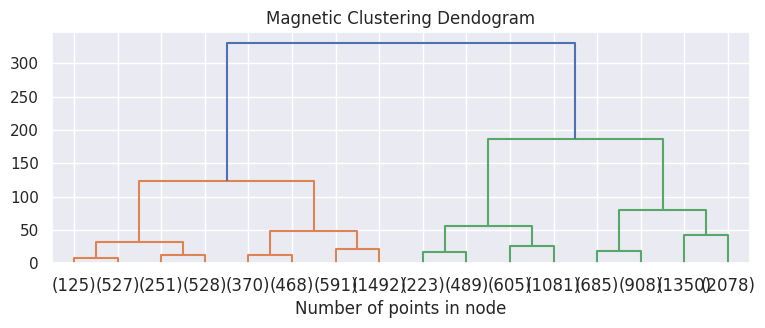

In [17]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

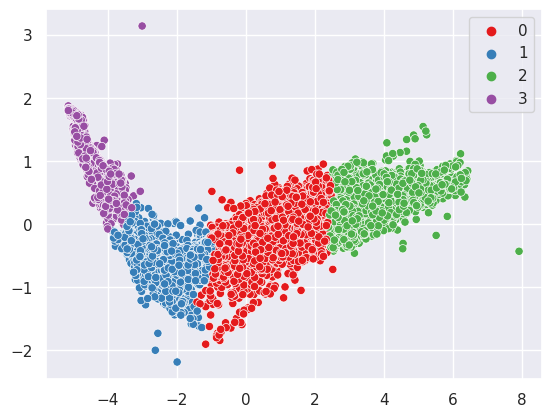

In [18]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

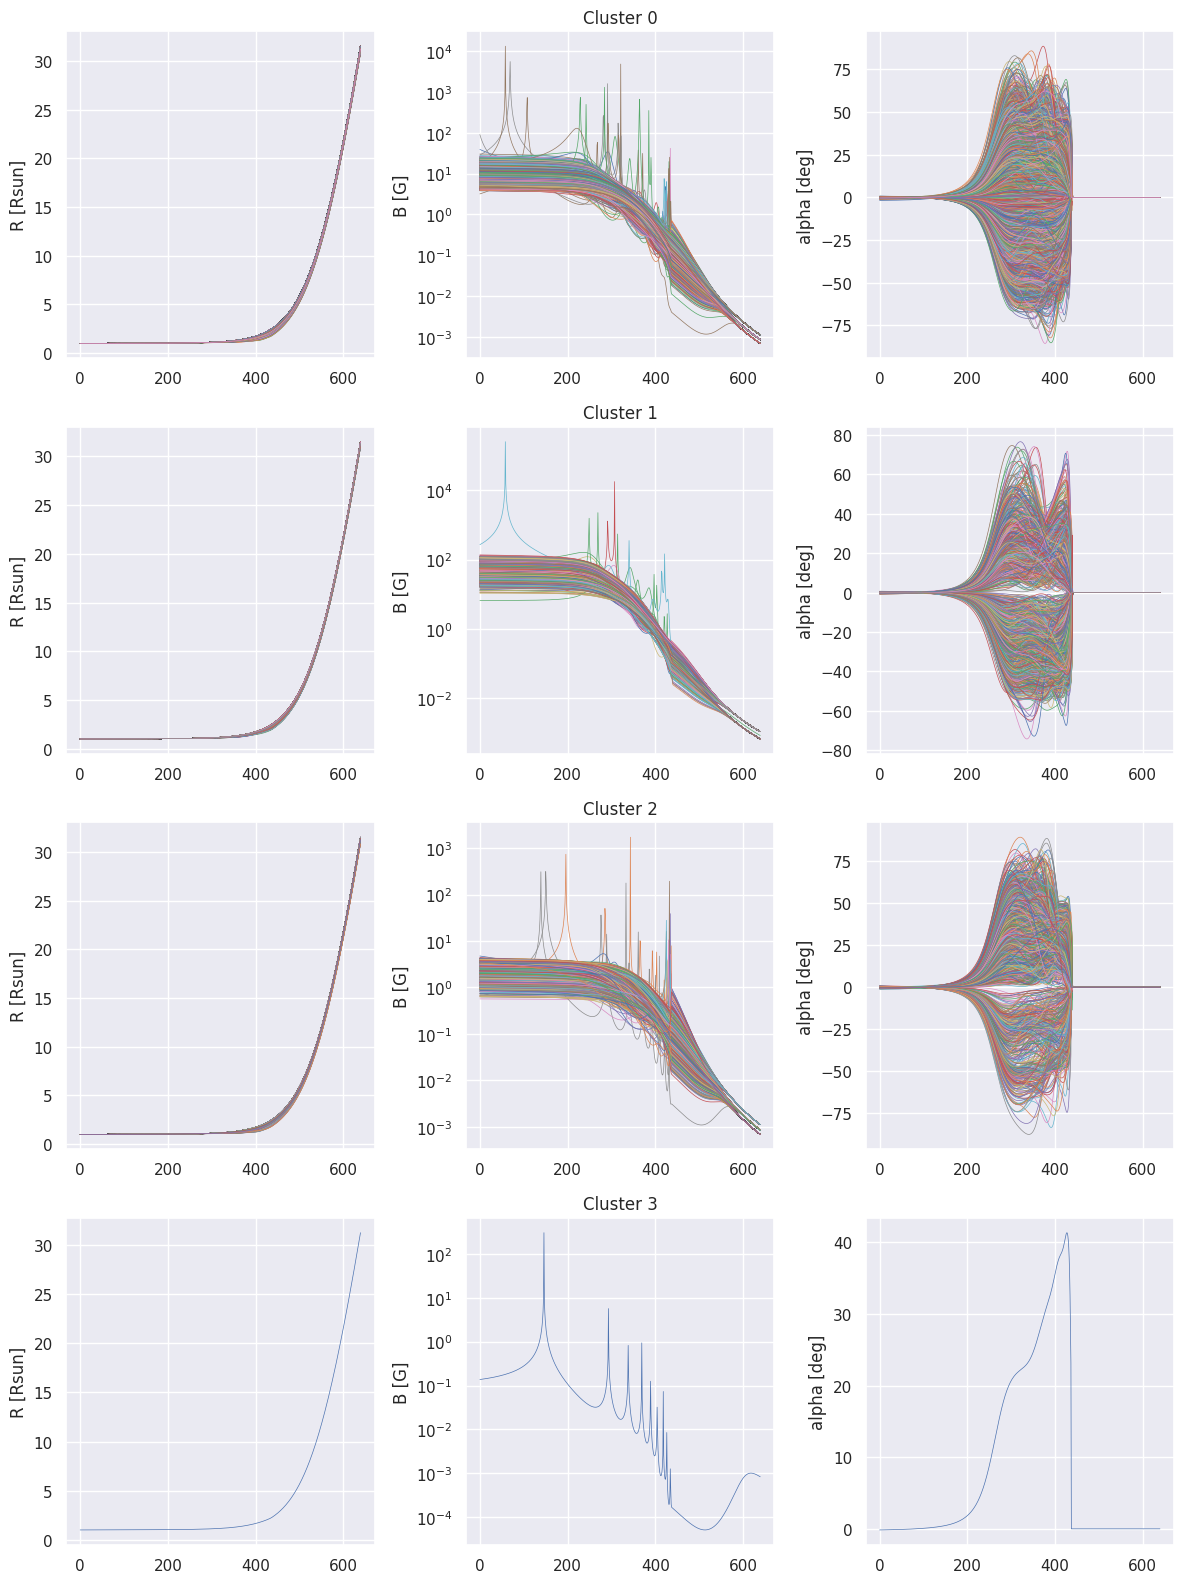

In [ ]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

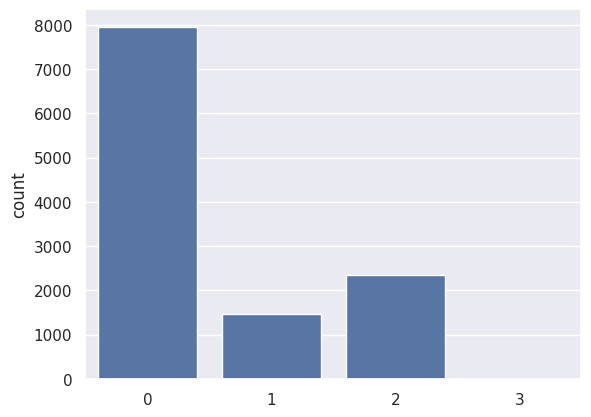

In [ ]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1583, 805, 112, 0], 'CR2056': [2284, 1, 276, 1], 'CR2071': [1495, 0, 678, 0], 'CR2125': [912, 652, 499, 0], 'CR2210': [1683, 0, 790, 0]}
[0, 1, 2, 3]


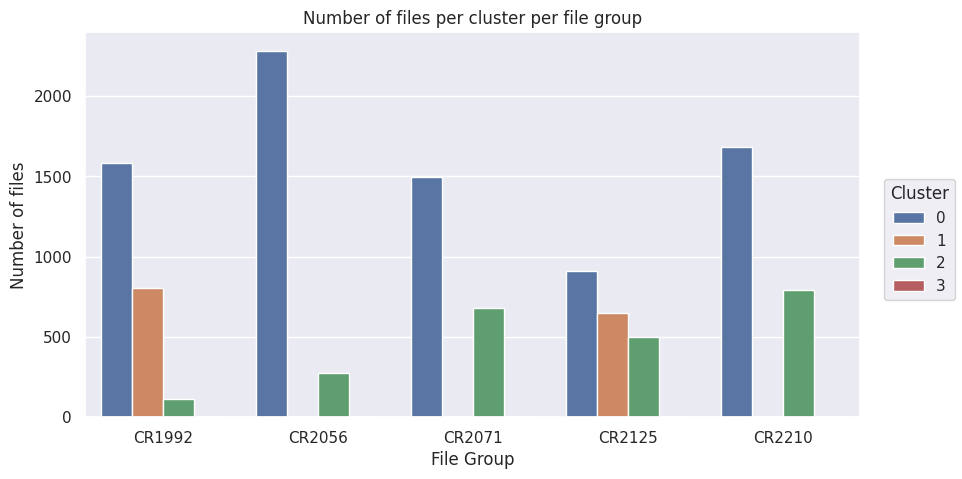

In [ ]:
fig = plot_cluster_file_group(filenames, agg.labels_, len(set(agg.labels_)))

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'mag'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_mag)
    
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'})
    

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=2)
dbscan_mag_labels = dbscan.fit_predict(transformed_mag)

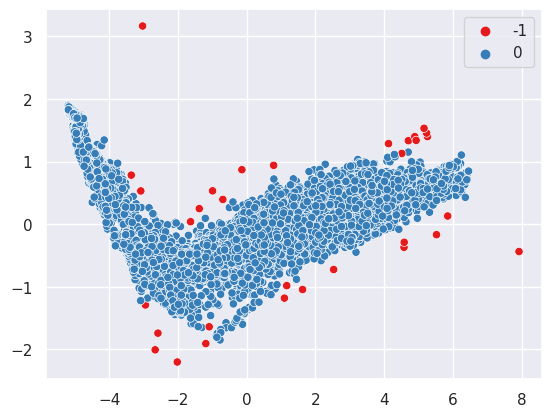

In [ ]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

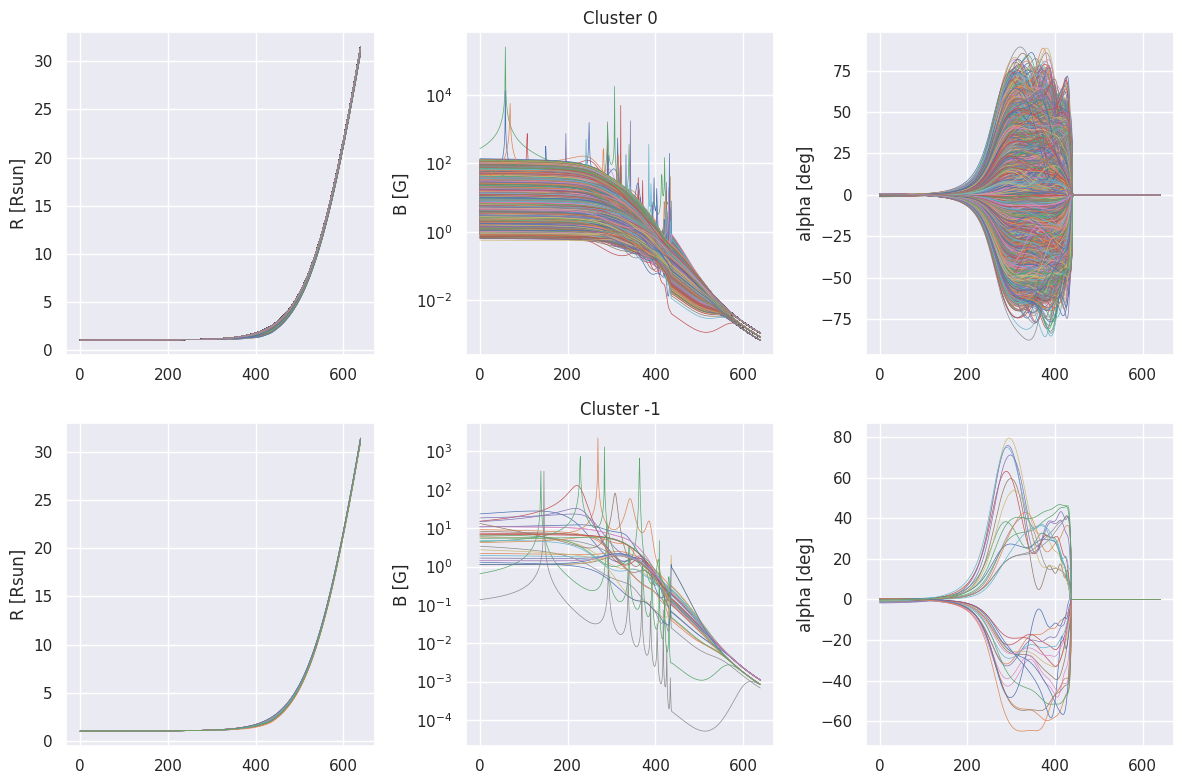

In [ ]:
plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

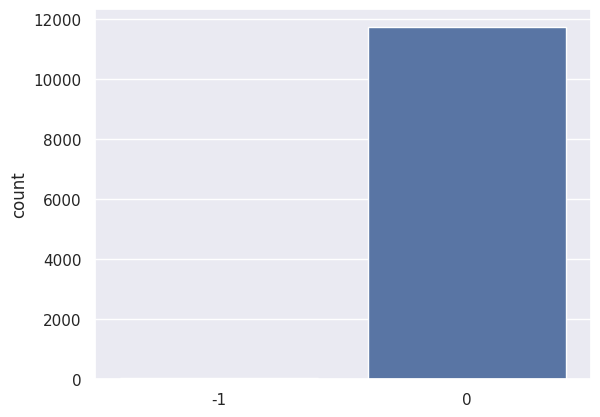

In [ ]:
sns.countplot(x=dbscan_mag_labels, color='b')

{'CR1992': [2481, 19], 'CR2056': [2558, 4], 'CR2071': [2167, 6], 'CR2125': [2062, 1], 'CR2210': [2470, 3]}
[0, -1]


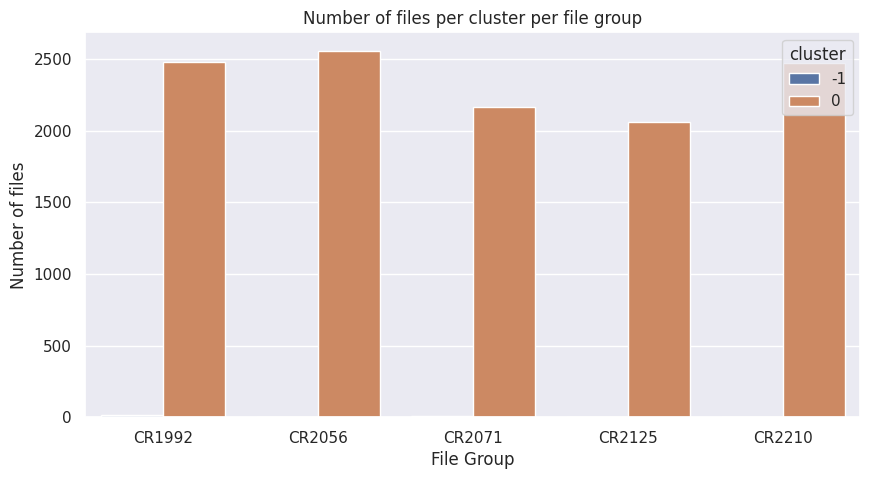

In [ ]:
fig = plot_cluster_file_group(filenames, dbscan_mag_labels, len(set(dbscan_mag_labels)))

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'mag_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()

# for i in np.arange(0.1, 0.35, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_mag_labels = dbscan.fit_predict(transformed_mag)
    
#     save_i = int(i*100)
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    

# Flux Tube Inclination - alpha [deg]

In [5]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.67442792, 0.67419734, 0.6739622 , 0.67372245, 0.67334731])

## PCA

In [6]:
pca = PCA(n_components=2)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[ 8.85459705, -0.27277131],
       [-6.36007484,  0.37319121],
       [-6.11669517, -0.53180041],
       ...,
       [-2.68159743,  0.84906513],
       [-5.28770219,  1.91061055],
       [-6.17733688,  0.05086762]])

### Transformed

<Axes: >

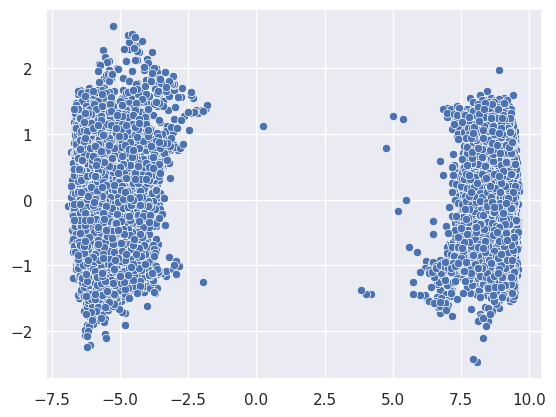

In [7]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

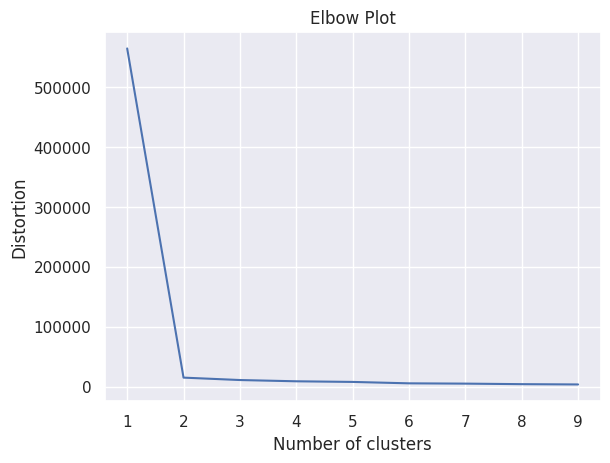

In [8]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto', random_state=1)
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [9]:
df = clustering_metrics(KMeans, transformed_alpha, {"n_init": "auto", "max_iter": 5000, "random_state": 1})
df

K   S score        DB             CH
0  2  0.898337  0.145496  428761.324987
1  3  0.586272  0.757380  294424.124790
2  4  0.593467  0.661943  243422.407205
3  5  0.583130  0.712616  207238.217032
4  6  0.400128  0.887166  237197.142377
5  7  0.391631  0.916825  216689.864483
6  8  0.390660  0.875102  225758.145524
7  9  0.380604  0.900676  223637.741926

In [10]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.898 & 0.145 & 428761.325 \\
3 & 0.586 & 0.757 & 294424.125 \\
4 & 0.593 & 0.662 & 243422.407 \\
5 & 0.583 & 0.713 & 207238.217 \\
6 & 0.400 & 0.887 & 237197.142 \\
7 & 0.392 & 0.917 & 216689.864 \\
8 & 0.391 & 0.875 & 225758.146 \\
9 & 0.381 & 0.901 & 223637.742 \\
\bottomrule
\end{tabular}



In [24]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

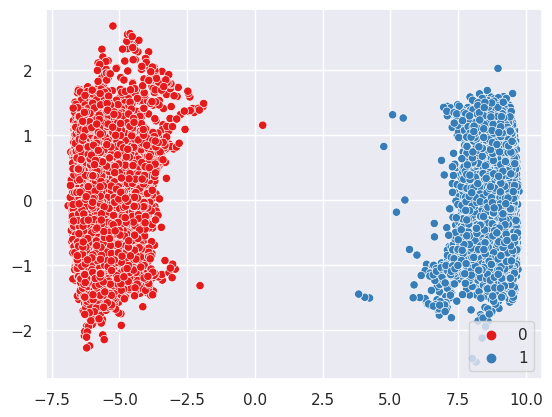

In [25]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

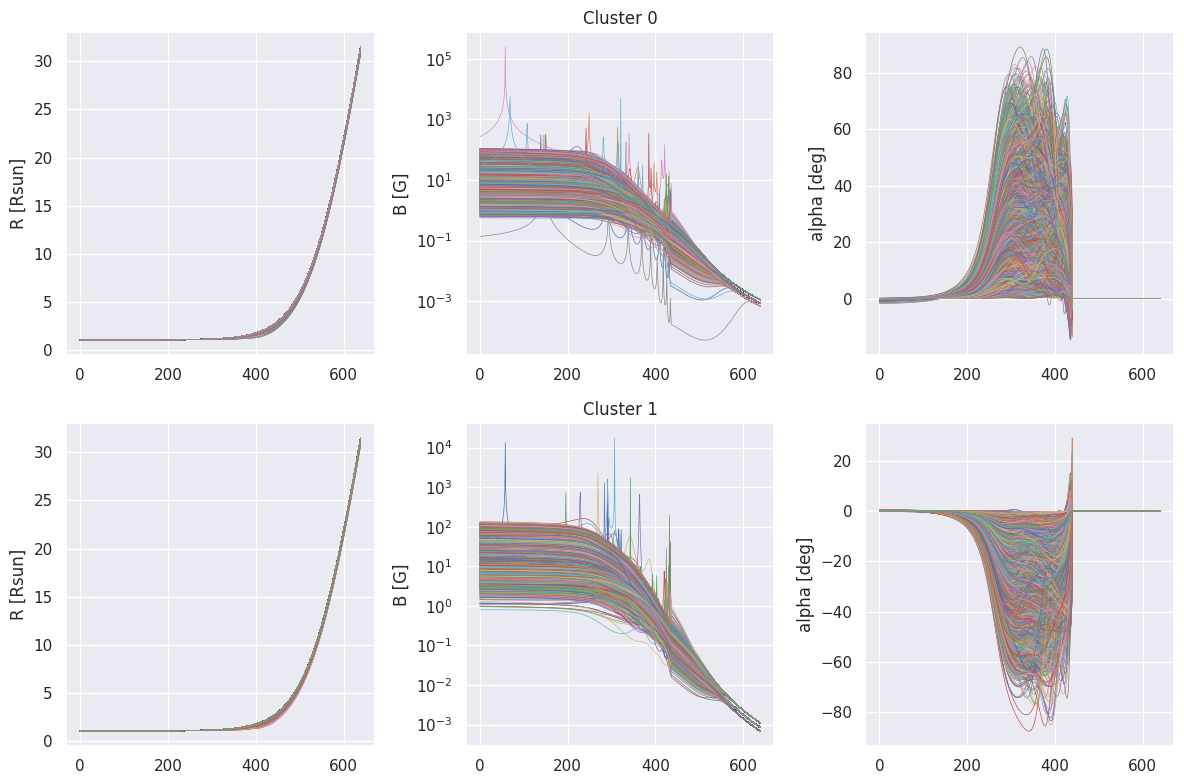

In [ ]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, 2, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

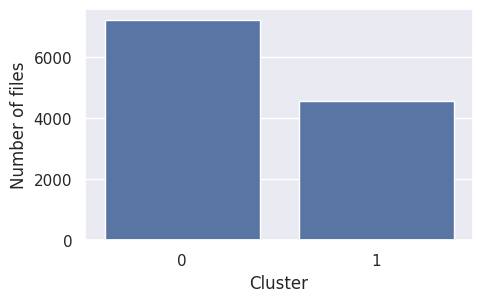

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [1161, 1339], 'CR2056': [1264, 1298], 'CR2071': [882, 1291], 'CR2125': [1428, 635], 'CR2210': [2473, 0]}
[0, 1]


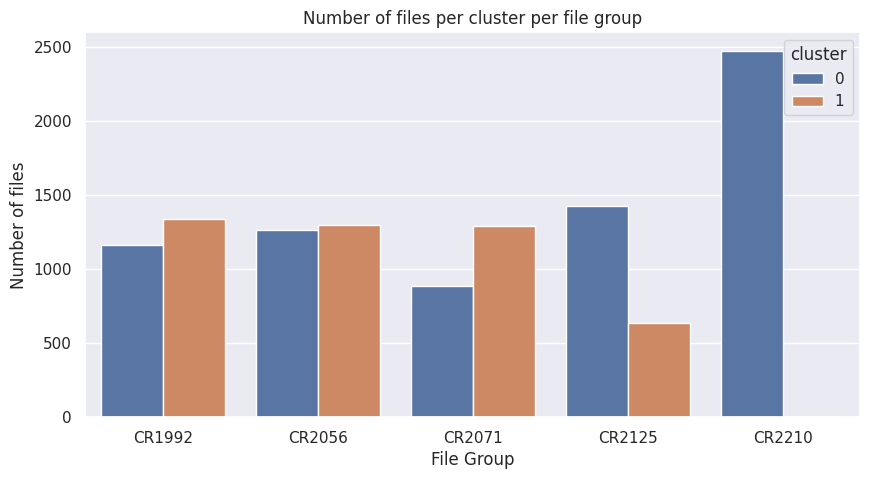

In [ ]:
fig = plot_cluster_file_group(filenames, pca_kmeans_alpha_labels, 2)

## Hierarchical Clustering

In [11]:
df = clustering_metrics(AgglomerativeClustering, transformed_alpha, {"linkage" : "ward", "compute_full_tree": True, "compute_distances": True})
df

K   S score        DB             CH
0  2  0.898337  0.145496  428761.324987
1  3  0.574197  0.782109  287595.691000
2  4  0.378327  1.021602  239082.632374
3  5  0.354234  0.954900  219099.226490
4  6  0.359298  0.923710  215351.383332
5  7  0.359911  0.900325  211272.095211
6  8  0.337854  0.906396  199083.503288
7  9  0.335552  0.889805  189224.359221

In [12]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.898 & 0.145 & 428761.325 \\
3 & 0.574 & 0.782 & 287595.691 \\
4 & 0.378 & 1.022 & 239082.632 \\
5 & 0.354 & 0.955 & 219099.226 \\
6 & 0.359 & 0.924 & 215351.383 \\
7 & 0.360 & 0.900 & 211272.095 \\
8 & 0.338 & 0.906 & 199083.503 \\
9 & 0.336 & 0.890 & 189224.359 \\
\bottomrule
\end{tabular}



In [27]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='ward')
agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

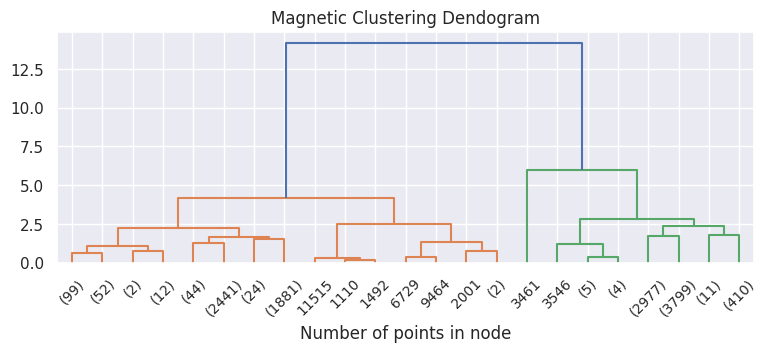

In [ ]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=4)
plt.xlabel("Number of points in node")

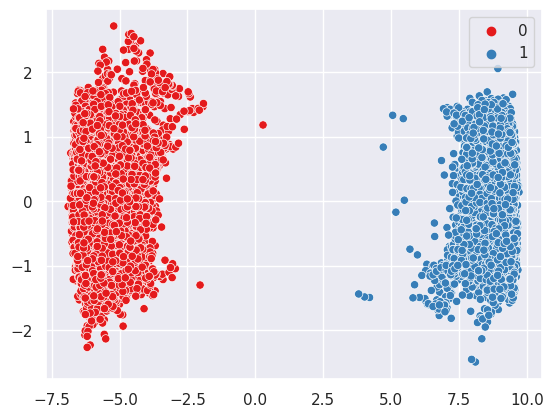

In [ ]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

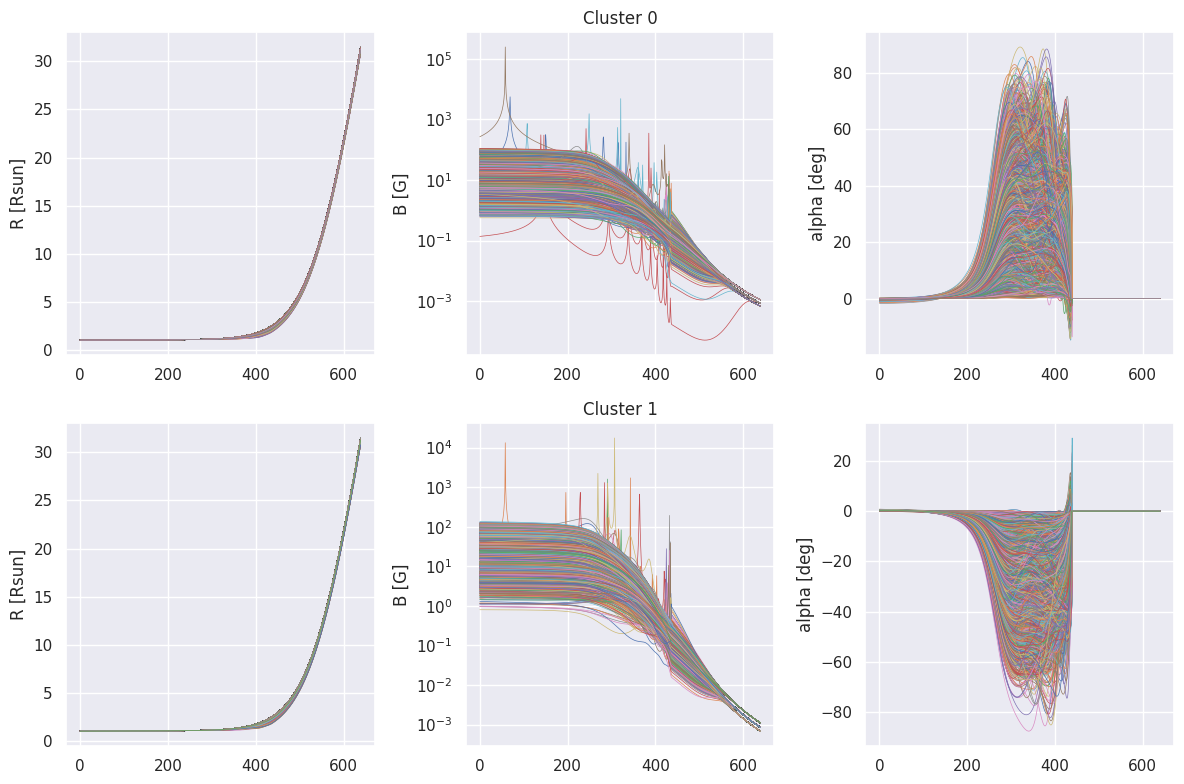

In [ ]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

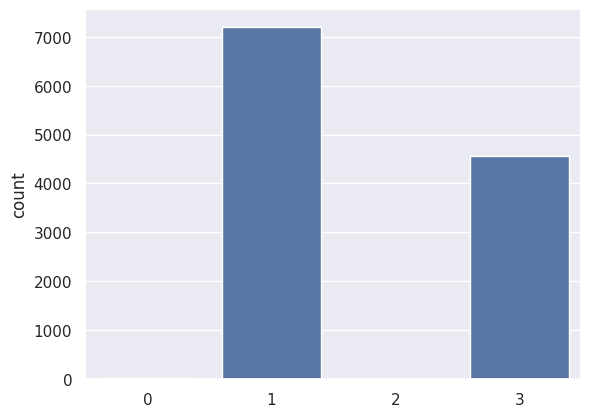

In [ ]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1, 1161, 0, 1338], 'CR2056': [1, 1263, 1, 1297], 'CR2071': [6, 882, 0, 1285], 'CR2125': [0, 1428, 0, 635], 'CR2210': [0, 2473, 0, 0]}
[0, 1, 2, 3]


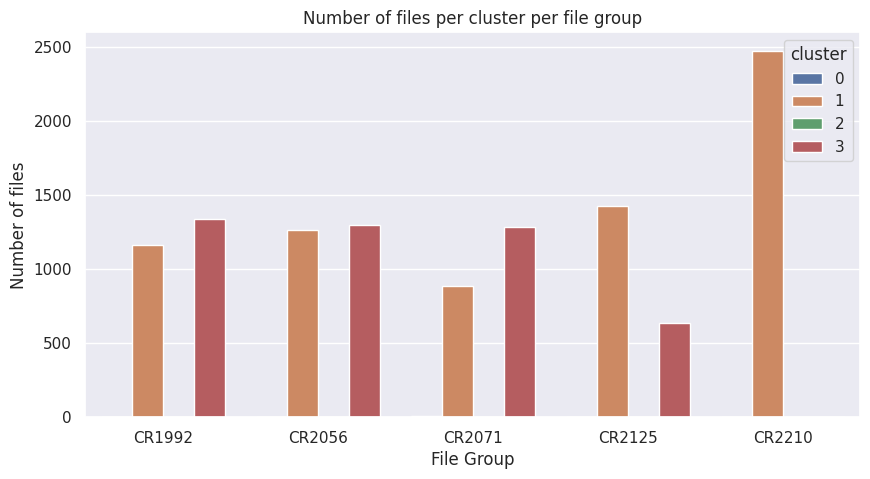

In [ ]:
fig = plot_cluster_file_group(filenames, agg.labels_, len(set(agg.labels_)))

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)


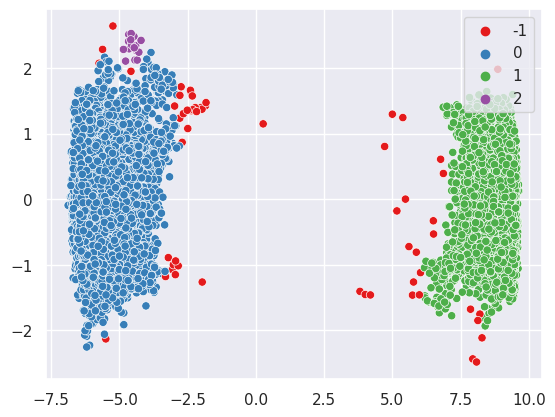

In [ ]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

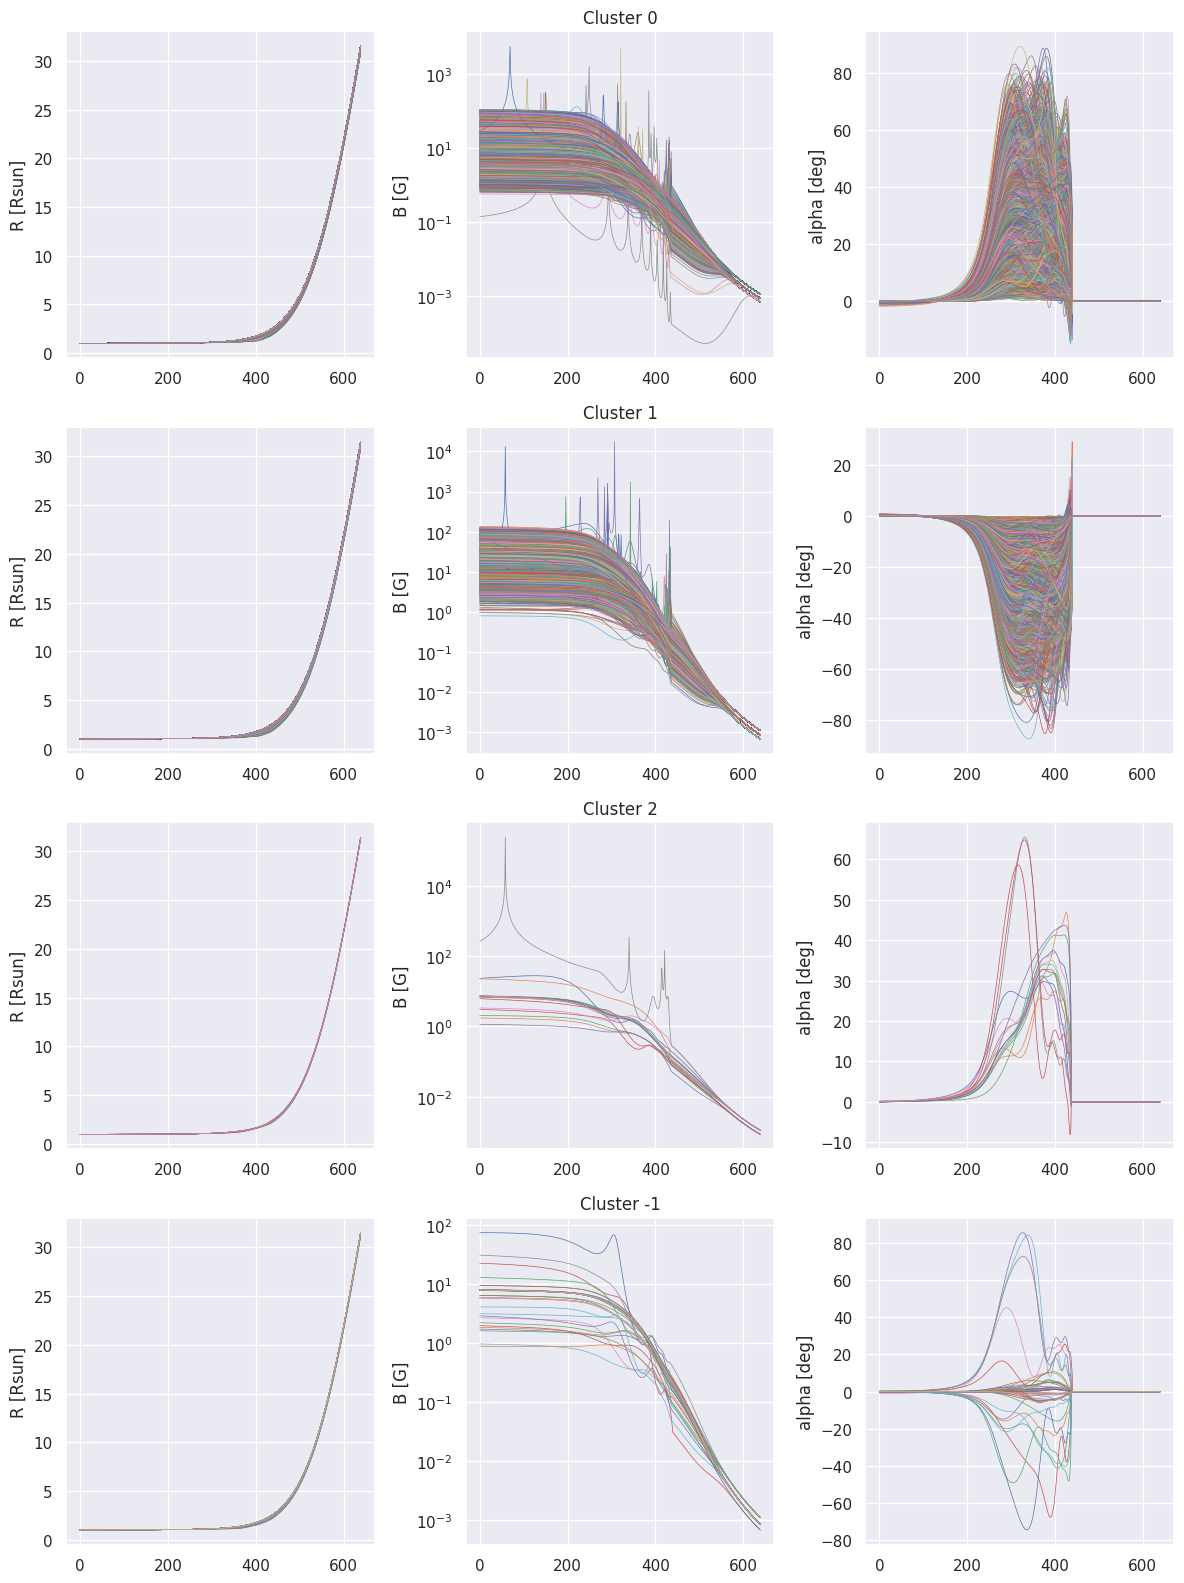

In [ ]:
plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

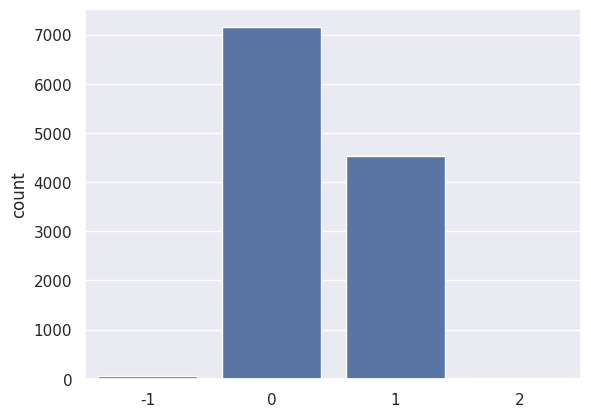

In [ ]:
sns.countplot(x=dbscan_alpha_labels, color='b')

{'CR1992': [1148, 1331, 12, 9], 'CR2056': [1246, 1297, 0, 19], 'CR2071': [878, 1274, 2, 19], 'CR2125': [1426, 635, 0, 2], 'CR2210': [2460, 0, 3, 10]}
[0, 1, 2, -1]


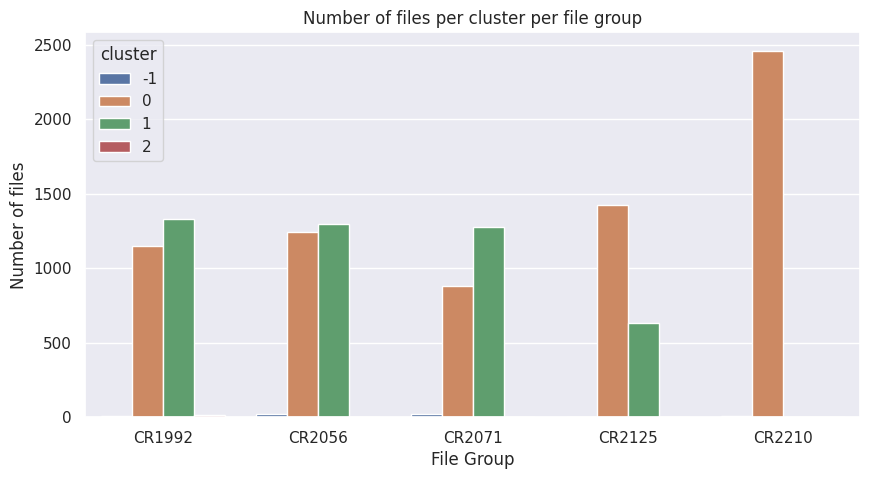

In [ ]:
f = plot_cluster_file_group(filenames, dbscan_alpha_labels, len(set(dbscan_alpha_labels)))

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    